In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup


In [17]:
print("📈 Fetching live AAPL stock data...")
end_date = datetime.now()
start_date = end_date - timedelta(days=90)

stock_df = yf.download("AAPL", start=start_date, end=end_date)
stock_df.reset_index(inplace=True)
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
print("✅ Stock data ready:", stock_df.shape)
stock_df.tail()


📈 Fetching live AAPL stock data...


C:\Users\Khushi\AppData\Local\Temp\ipykernel_8100\45239108.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download("AAPL", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

✅ Stock data ready: (62, 6)


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
57,2025-11-20,266.250000,275.429993,265.920013,270.829987,45823600
58,2025-11-21,271.489990,273.329987,265.670013,265.950012,59030800
59,2025-11-24,275.920013,277.000000,270.899994,270.899994,65585800
60,2025-11-25,276.970001,280.380005,275.250000,275.269989,46914200
61,2025-11-26,277.549988,279.529999,276.630005,276.959991,33431400


In [18]:
def fetch_live_news(symbol="apple"):
    print(f"📰 Fetching latest {symbol} news...")
    url = f"https://www.google.com/finance/quote/{symbol}:NASDAQ"
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(r.text, 'html.parser')
    headlines = [tag.text for tag in soup.find_all('div', class_='Yfwt5')]
    
    analyzer = SentimentIntensityAnalyzer()
    today = datetime.now().date()
    data = []
    for h in headlines[:10]:
        score = analyzer.polarity_scores(h)['compound']
        data.append([today, h, score])
    
    df = pd.DataFrame(data, columns=['Date', 'Title', 'Sentiment'])
    df['Date'] = pd.to_datetime(df['Date'])
    print(f"✅ Collected {len(df)} live headlines")
    return df

news_df = fetch_live_news("AAPL")
news_df.head()


📰 Fetching latest AAPL news...
✅ Collected 4 live headlines


,Date,Title,Sentiment
0,2025-11-28,Apple original company creation papers to be a...,0.5267
1,2025-11-28,Black Friday Sale effect? Employee earning Rs ...,0.0000
2,2025-11-28,iPhone 17 Tipped to Receive a Price Hike in In...,-0.3612
3,2025-11-28,"Apple, Meta, Starbucks and more set to report ...",0.0000


In [19]:
def combine_data(stock_df, news_df):
    # --- Fix for multi-index columns (e.g., ('Close', 'AAPL')) ---
    if isinstance(stock_df.columns, pd.MultiIndex):
        stock_df.columns = [col[0] if isinstance(col, tuple) else col for col in stock_df.columns]

    # --- Ensure 'Close' exists ---
    if 'Close' not in stock_df.columns:
        close_candidates = [c for c in stock_df.columns if 'close' in c.lower()]
        if close_candidates:
            stock_df.rename(columns={close_candidates[0]: 'Close'}, inplace=True)
        else:
            raise KeyError("Couldn't find 'Close' column in stock_df")

    # --- Clean ---
    stock_df = stock_df.copy()
    news_df = news_df.copy()
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    news_df['Date'] = pd.to_datetime(news_df['Date'])

    # --- Merge sentiment by Date ---
    merged = pd.merge(stock_df, news_df[['Date', 'Sentiment']], on='Date', how='left')
    merged['Sentiment'] = merged['Sentiment'].fillna(0)

    # --- Create target variable (1 = next day up, 0 = down) ---
    merged['Target'] = np.where(merged['Close'].shift(-1) > merged['Close'], 1, 0)
    merged.dropna(inplace=True)

    print("✅ Combined dataset ready!")
    print("Columns available:", merged.columns.tolist())
    return merged

final_df = combine_data(stock_df, news_df)
final_df.head()


✅ Combined dataset ready!
Columns available: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Sentiment', 'Target']


,Date,Close,High,Low,Open,Volume,Sentiment,Target
0,2025-09-02,229.497528,230.626439,226.750191,229.027982,44075600,0.0,1
1,2025-09-03,238.239059,238.618696,234.133039,236.980285,66427800,0.0,1
2,2025-09-04,239.547775,239.667654,236.510726,238.219062,47549400,0.0,0
3,2025-09-05,239.457870,241.086297,238.259036,239.767568,54870400,0.0,0
4,2025-09-08,237.649628,239.917418,236.111111,239.068251,48999500,0.0,0


In [20]:
def train_model(final_df):
    X = final_df[['Close', 'Sentiment']]
    y = final_df['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    print("✅ Model trained successfully!")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model, scaler

model, scaler = train_model(final_df)


✅ Model trained successfully!
Accuracy: 0.46
Confusion Matrix:
 [[0 7]
 [0 6]]


In [21]:
def predict_next_day(stock_df, news_df, model, scaler):
    latest_close = stock_df['Close'].iloc[-1]
    latest_sentiment = news_df['Sentiment'].mean() if not news_df.empty else 0

    X_live = pd.DataFrame([[latest_close, latest_sentiment]], columns=['Close', 'Sentiment'])
    X_live_scaled = scaler.transform(X_live)

    prediction = model.predict(X_live_scaled)[0]
    direction = "📈 UP" if prediction == 1 else "📉 DOWN"

    print(f"\n🔮 Latest Close: {latest_close:.2f}")
    print(f"🧠 Average Sentiment Today: {latest_sentiment:.3f}")
    print(f"💡 Predicted Next Day Direction: {direction}")

predict_next_day(stock_df, news_df, model, scaler)



🔮 Latest Close: 277.55
🧠 Average Sentiment Today: 0.041
💡 Predicted Next Day Direction: 📈 UP


In [22]:
def combine_data(stock_df, news_df):
    # --- Reset index so 'Date' is a column ---
    stock_df = stock_df.reset_index()
    
    # --- Flatten multi-level columns (like ('Close', 'AAPL')) ---
    if isinstance(stock_df.columns, pd.MultiIndex):
        stock_df.columns = [col[0] if isinstance(col, tuple) else col for col in stock_df.columns]
    
    news_df = news_df.copy()
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    news_df['Date'] = pd.to_datetime(news_df['Date'])
    
    # --- Merge on Date ---
    merged = pd.merge(stock_df, news_df[['Date', 'Sentiment']], on='Date', how='left')
    merged['Sentiment'] = merged['Sentiment'].fillna(0)

    # --- Create Target variable (1 if price goes up next day) ---
    merged['Target'] = np.where(merged['Close'].shift(-1) > merged['Close'], 1, 0)
    merged.dropna(inplace=True)
    
    return merged


In [23]:
# Analyze multiple stocks
symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

results = []

for sym in symbols:
    print(f"\n🚀 Running analysis for {sym}...")
    
    # Fetch stock + news
    stock_df = yf.download(sym, period="3mo")
    news_df = fetch_live_news(sym)
    
    # Combine data
    final_df = combine_data(stock_df, news_df)
    
    # Train + scale
    model, scaler = train_model(final_df)
    
    # Predict next day
    latest_close = stock_df['Close'].iloc[-1]
    latest_sentiment = news_df['Sentiment'].mean() if not news_df.empty else 0
    X_live = pd.DataFrame([[latest_close, latest_sentiment]], columns=['Close', 'Sentiment'])
    X_live_scaled = scaler.transform(X_live)
    prediction = model.predict(X_live_scaled)[0]
    direction = "📈 UP" if prediction == 1 else "📉 DOWN"
    
    results.append([sym, latest_close, latest_sentiment, direction])

results_df = pd.DataFrame(results, columns=["Stock", "Latest Close", "Avg Sentiment", "Predicted Direction"])
print("\n✅ All Stock Predictions:\n")
display(results_df)



🚀 Running analysis for AAPL...


C:\Users\Khushi\AppData\Local\Temp\ipykernel_8100\3010924458.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download(sym, period="3mo")
[*********************100%***********************]  1 of 1 completed


📰 Fetching latest AAPL news...
✅ Collected 4 live headlines
✅ Model trained successfully!
Accuracy: 0.46
Confusion Matrix:
 [[0 7]
 [0 6]]

🚀 Running analysis for MSFT...


C:\Users\Khushi\AppData\Local\Temp\ipykernel_8100\3010924458.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download(sym, period="3mo")
[*********************100%***********************]  1 of 1 completed


📰 Fetching latest MSFT news...
✅ Collected 4 live headlines
✅ Model trained successfully!
Accuracy: 0.46
Confusion Matrix:
 [[0 7]
 [0 6]]

🚀 Running analysis for GOOGL...


C:\Users\Khushi\AppData\Local\Temp\ipykernel_8100\3010924458.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download(sym, period="3mo")
[*********************100%***********************]  1 of 1 completed


📰 Fetching latest GOOGL news...
✅ Collected 2 live headlines
✅ Model trained successfully!
Accuracy: 0.62
Confusion Matrix:
 [[6 1]
 [4 2]]

🚀 Running analysis for AMZN...


C:\Users\Khushi\AppData\Local\Temp\ipykernel_8100\3010924458.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download(sym, period="3mo")
[*********************100%***********************]  1 of 1 completed


📰 Fetching latest AMZN news...
✅ Collected 6 live headlines
✅ Model trained successfully!
Accuracy: 0.46
Confusion Matrix:
 [[2 6]
 [1 4]]

🚀 Running analysis for TSLA...


C:\Users\Khushi\AppData\Local\Temp\ipykernel_8100\3010924458.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_df = yf.download(sym, period="3mo")
[*********************100%***********************]  1 of 1 completed


📰 Fetching latest TSLA news...
✅ Collected 4 live headlines
✅ Model trained successfully!
Accuracy: 0.46
Confusion Matrix:
 [[0 7]
 [0 6]]

✅ All Stock Predictions:



,Stock,Latest Close,Avg Sentiment,Predicted Direction
0,AAPL,Ticker AAPL 277.549988 Name: 2025-11-26 00:...,0.041375,📈 UP
1,MSFT,Ticker MSFT 485.5 Name: 2025-11-26 00:00:00...,0.273925,📈 UP
2,GOOGL,Ticker GOOGL 319.950012 Name: 2025-11-26 00...,0.084050,📉 DOWN
3,AMZN,Ticker AMZN 229.160004 Name: 2025-11-26 00:...,0.022200,📈 UP
4,TSLA,Ticker TSLA 426.579987 Name: 2025-11-26 00:...,0.038625,📈 UP


C:\Users\Khushi\AppData\Local\Temp\ipykernel_8100\4261885182.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, period="3mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\Khushi\AppData\Local\Temp\ipykernel_8100\4261885182.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, period="3mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\Khushi\AppData\Local\Temp\ipykernel_8100\4261885182.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, period="3mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\Khushi\AppData\Local\Temp\ipykernel_8100\4261885182.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, period="3mo")
[*********************100%***********************]  1 of 1 co

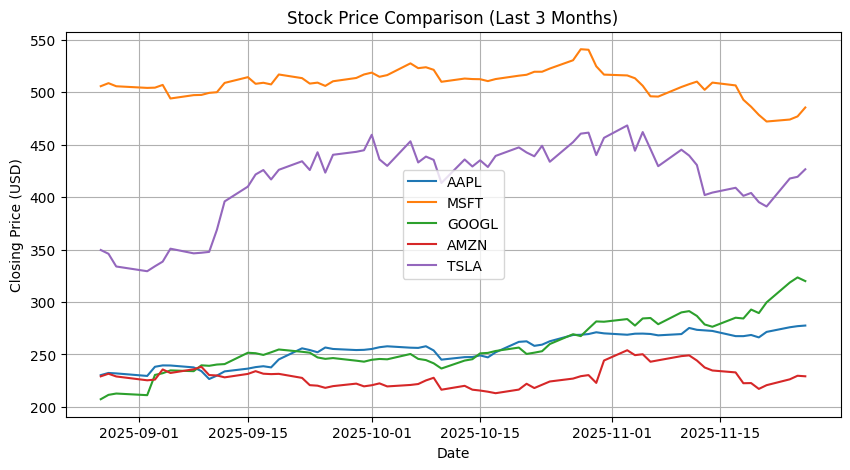

In [24]:
# Visualize 5-stock closing prices over time
plt.figure(figsize=(10,5))
for sym in symbols:
    df = yf.download(sym, period="3mo")
    plt.plot(df.index, df["Close"], label=sym)

plt.title("Stock Price Comparison (Last 3 Months)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


📰 Fetching latest AAPL news...
✅ Collected 4 live headlines
📰 Fetching latest MSFT news...
✅ Collected 4 live headlines
📰 Fetching latest GOOGL news...
✅ Collected 2 live headlines
📰 Fetching latest AMZN news...
✅ Collected 6 live headlines
📰 Fetching latest TSLA news...
✅ Collected 4 live headlines


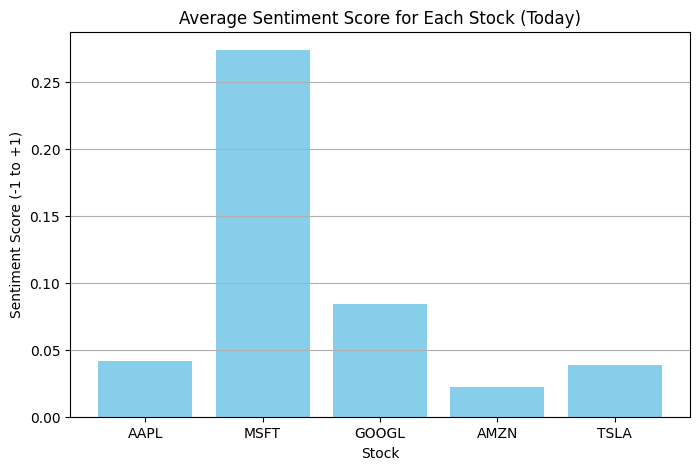

In [25]:
# Sentiment comparison (based on scraped headlines)
sentiments = []

for sym in symbols:
    news_df = fetch_live_news(sym)
    if not news_df.empty:
        avg_sent = news_df["Sentiment"].mean()
    else:
        avg_sent = 0
    sentiments.append(avg_sent)

plt.figure(figsize=(8,5))
plt.bar(symbols, sentiments, color='skyblue')
plt.title("Average Sentiment Score for Each Stock (Today)")
plt.xlabel("Stock")
plt.ylabel("Sentiment Score (-1 to +1)")
plt.grid(True, axis='y')
plt.show()
